In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter


import keras
from keras import models
from keras import layers
import tensorflow as tf
from keras.backend import binary_crossentropy
from keras import backend as K
from keras.callbacks import Callback
from keras import optimizers
from keras.backend import mean
from keras import regularizers
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.clear_session()

W0930 00:13:17.076769 140420415530816 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0930 00:13:17.077919 140420415530816 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0930 00:13:17.085556 140420415530816 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [3]:
path = '/home/ricardo/TCC/'

In [4]:
df = pd.read_csv(path+'train.csv', sep = ',')
X = df.loc[:,'var_0':'var_199']
Y = df.loc[:,'target']

In [5]:
meanX = X.mean(axis = 0)
stdX = X.std(axis = 0)
X_norm = (X-meanX)/stdX

In [6]:
fraud_index = np.where(Y==1)
honest_index = np.where(Y==0)
fraud = X_norm.loc[fraud_index]
honest = X_norm.loc[honest_index]

yh = Y.loc[honest_index]
yf = Y.loc[fraud_index]

In [7]:
h_used, x_trash, yh, y_trash = train_test_split(honest, yh, test_size = 0.75, random_state = 30)
x_used = pd.concat([h_used,fraud],ignore_index = False)
y_used = pd.concat([yh,yf],ignore_index=False)
x_train,x_test,y_train,y_test = train_test_split(x_used,y_used,test_size=0.3,random_state = 30)
x_val,x_test,y_val,y_test = train_test_split(x_test,y_test,test_size=0.5,random_state = 30)

In [8]:
x_data = [x_train,x_val,x_test]
y_data = [y_train,y_val,y_test]

print('Size of Train Data: {0}, not anomalys/anomaly:{1}'.format(len(x_data[0]),Counter(y_data[0])))
print('Size of val Data: {0}, not anomalys/anomaly:{1}'.format(len(x_data[1]),Counter(y_data[1])))
print('Size of test Data: {0}, not anomalys/anomaly:{1}'.format(len(x_data[2]),Counter(y_data[2])))

Size of Train Data: 45551, not anomalys/anomaly:Counter({0: 31412, 1: 14139})
Size of val Data: 9761, not anomalys/anomaly:Counter({0: 6779, 1: 2982})
Size of test Data: 9761, not anomalys/anomaly:Counter({0: 6784, 1: 2977})


In [9]:
def f1Score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [10]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [11]:
model = models.Sequential()
model.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,),
                       kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units = 1,activation = 'sigmoid'))

model.summary()

W0930 00:13:34.458242 140420415530816 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0930 00:13:34.461085 140420415530816 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0930 00:13:34.494198 140420415530816 deprecation.py:506] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
_________________________________________________________________


In [12]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model.fit(x_train,y_train,epochs = 2000, validation_data =(x_val, y_val),verbose = 0)

W0930 00:13:34.569641 140420415530816 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0930 00:13:34.584471 140420415530816 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


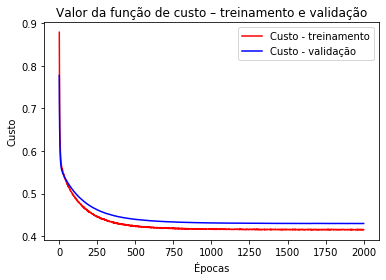

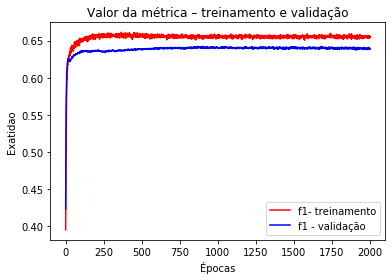

In [13]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [14]:
def choosing_threshold(y_true,y_prob,threshold_list):
    y_hat = []
    precision = []
    recall = []
    f1 = []
    y_h = []
    for threshold in threshold_list:
        for i in range(len(y_true)):
            if y_prob[i]>threshold:
                y_hat.append(1)
            else:
                y_hat.append(0)
        precision.append(precision_score(y_true,y_hat))
        recall.append(recall_score(y_true,y_hat))
        f1.append(f1_score(y_true,y_hat))
        y_h.append(y_hat)
        y_hat = []
    return(precision,recall,f1,y_h)                       

In [15]:
prob = np.ravel(model.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)

In [16]:
print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

precision values: [0.4371615008156607, 0.4883897404765518, 0.5335930735930736, 0.5759949091977091, 0.6145781603487281, 0.6488146419358801, 0.6827890312801433, 0.7135918587618534, 0.7453932001038152, 0.7764163889433444, 0.804038137969714, 0.8288137771494667, 0.8546853779990946, 0.8763596809282088, 0.9011441647597254, 0.9260068685607243, 0.9512195121951219, 0.985]
recall values: [0.9476624938114435, 0.9103897022420256, 0.8717731098380367, 0.8322370747577622, 0.7877501944974892, 0.7471532640215008, 0.7008982247683712, 0.6546431855152415, 0.6093783152981116, 0.5602234952966971, 0.5069665464318551, 0.45611429379729823, 0.40059410142159985, 0.34189122285875945, 0.27852040455477756, 0.2097743829125115, 0.13515807341396138, 0.055732371454841216]
f1 values: [0.5983165509388466, 0.6357328065193233, 0.6619941459222859, 0.6808030548484147, 0.6904717624449818, 0.6945202327339668, 0.6917251247687851, 0.682847657690889, 0.6705580200793836, 0.6508360379606426, 0.6218443654029668, 0.588412408759124, 0.

Normalized confusion matrix
[[0.45081498 0.54918502]
 [0.05233751 0.94766249]]
Normalized confusion matrix
[[0.5707373 0.4292627]
 [0.0896103 0.9103897]]
Normalized confusion matrix
[[0.65701006 0.34298994]
 [0.12822689 0.87177311]]
Normalized confusion matrix
[[0.72424551 0.27575449]
 [0.16776293 0.83223707]]
Normalized confusion matrix
[[0.77763275 0.22236725]
 [0.21224981 0.78775019]]
Normalized confusion matrix
[[0.81796766 0.18203234]
 [0.25284674 0.74715326]]
Normalized confusion matrix
[[0.85343181 0.14656819]
 [0.29910178 0.70089822]]
Normalized confusion matrix
[[0.8817331  0.1182669 ]
 [0.34535681 0.65464319]]
Normalized confusion matrix
[[0.90630969 0.09369031]
 [0.39062168 0.60937832]]
Normalized confusion matrix
[[0.92738444 0.07261556]
 [0.4397765  0.5602235 ]]
Normalized confusion matrix
[[0.94438431 0.05561569]
 [0.49303345 0.50696655]]
Normalized confusion matrix
[[0.95759582 0.04240418]
 [0.54388571 0.45611429]]
Normalized confusion matrix
[[0.96934293 0.03065707]
 [0

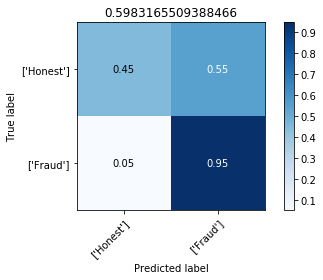

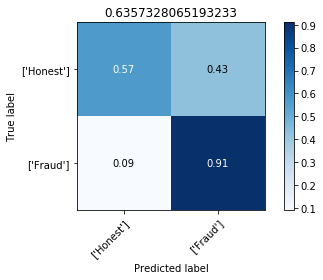

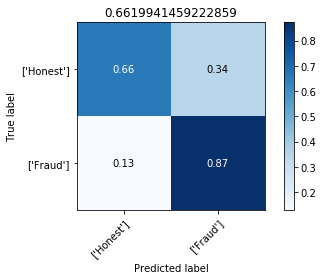

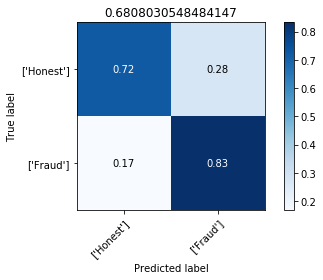

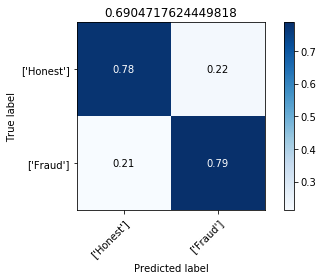

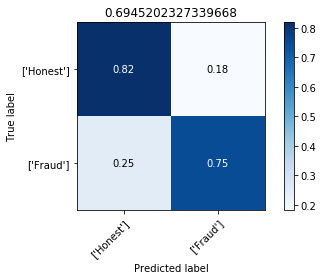

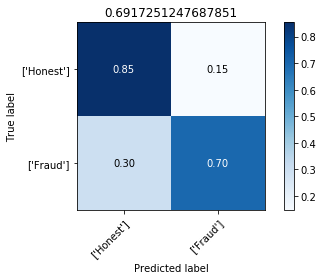

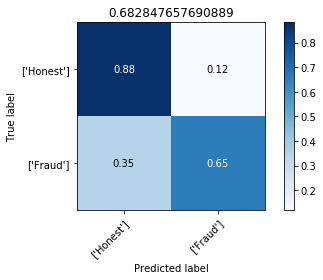

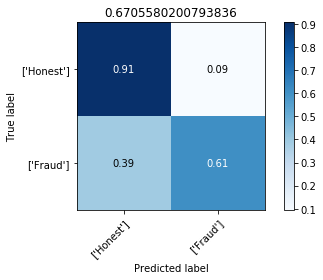

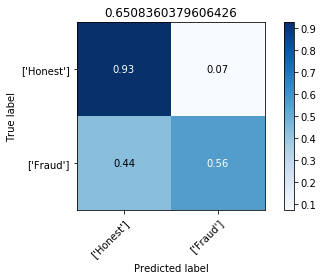

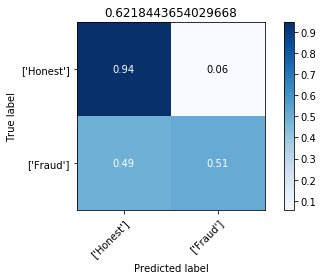

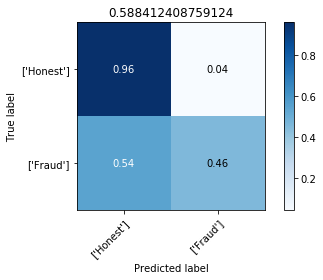

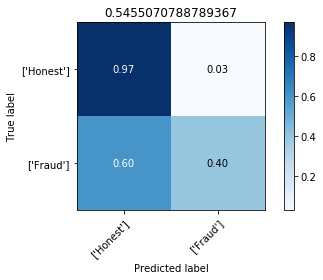

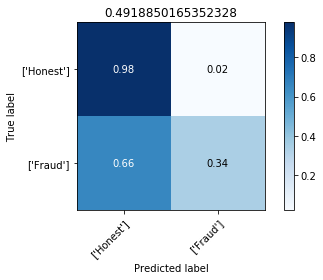

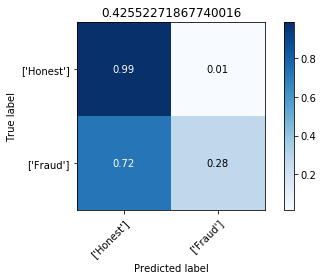

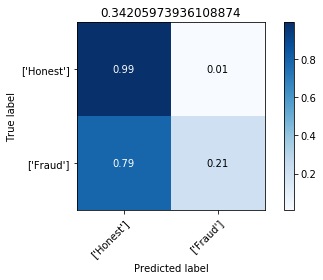

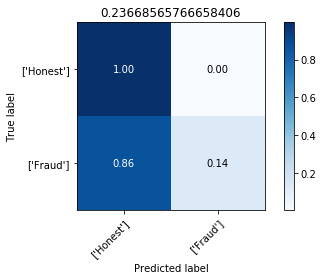

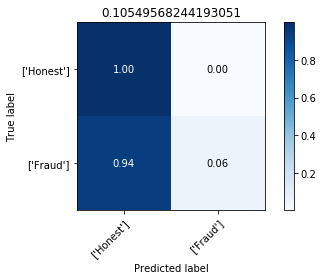

In [17]:
for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [18]:
model.save('/home/ricardo/TCC/Undersampling/models/RNA1')

OSError: Unable to create file (unable to open file: name = '/home/ricardo/TCC/Undersampling/models/RNA1', errno = 21, error message = 'Is a directory', flags = 13, o_flags = 242)

In [18]:
K.clear_session()

In [19]:
model1 = models.Sequential()
model1.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,)
                        ,kernel_regularizer=regularizers.l2(0.01)))
model1.add(layers.Dropout(0.3))
model1.add(layers.Dense(units = 1,activation = 'sigmoid'))

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
_________________________________________________________________


In [20]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)

In [21]:
model1.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)

In [22]:
history1 = model1.fit(x_train,y_train,epochs = 2000, validation_data =(x_val, y_val),verbose = 0)

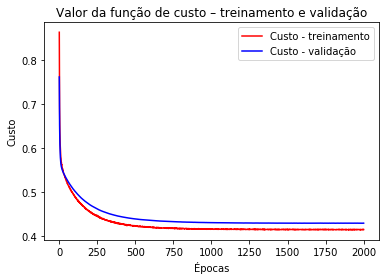

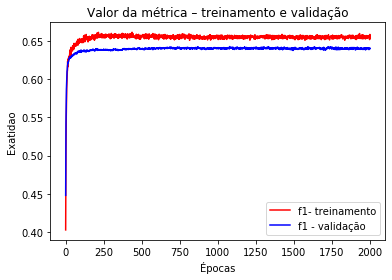

In [23]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [24]:
prob = np.ravel(model1.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)

In [26]:
print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

precision values: [0.43498165524854704, 0.4860780535721032, 0.5316864976720124, 0.5750611246943765, 0.6121831876408819, 0.6489788363053002, 0.6819155552484278, 0.7146850974605886, 0.7470480188926791, 0.7765091342335186, 0.8043948536946374, 0.830032786885246, 0.8575423333851173, 0.8809613218174991, 0.9049988154465767, 0.9284542172628816, 0.9558902635825712, 0.9795640326975477]
recall values: [0.947521041092015, 0.90996534408374, 0.8722681943560365, 0.8317419902397624, 0.7875380154183464, 0.7438998514746445, 0.697927717660372, 0.6508946884503855, 0.6040738383195416, 0.5531508593252705, 0.4996817313812858, 0.4476271306315864, 0.3904095056227456, 0.3318480797793338, 0.27017469410849426, 0.2000848716316571, 0.1256807412122498, 0.0508522526345569]
f1 values: [0.5962437135609061, 0.6336682427107959, 0.6606669345118522, 0.6799849663187719, 0.6888765157139322, 0.6932050352600014, 0.6898287312128626, 0.6812999703879183, 0.6679962458939466, 0.6460699681962744, 0.6164383561643836, 0.58160264657232

Normalized confusion matrix
[[0.4460079  0.5539921 ]
 [0.05247896 0.94752104]]
Normalized confusion matrix
[[0.56694894 0.43305106]
 [0.09003466 0.90996534]]
Normalized confusion matrix
[[0.65417675 0.34582325]
 [0.12773181 0.87226819]]
Normalized confusion matrix
[[0.72335413 0.27664587]
 [0.16825801 0.83174199]]
Normalized confusion matrix
[[0.77543614 0.22456386]
 [0.21246198 0.78753802]]
Normalized confusion matrix
[[0.81889087 0.18110913]
 [0.25610015 0.74389985]]
Normalized confusion matrix
[[0.85346364 0.14653636]
 [0.30207228 0.69792772]]
Normalized confusion matrix
[[0.88303833 0.11696167]
 [0.34910531 0.65089469]]
Normalized confusion matrix
[[0.90793327 0.09206673]
 [0.39592616 0.60407384]]
Normalized confusion matrix
[[0.92833949 0.07166051]
 [0.44684914 0.55315086]]
Normalized confusion matrix
[[0.94530753 0.05469247]
 [0.50031827 0.49968173]]
Normalized confusion matrix
[[0.95874188 0.04125812]
 [0.55237287 0.44762713]]
Normalized confusion matrix
[[0.97080733 0.02919267]

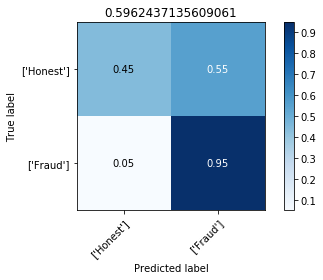

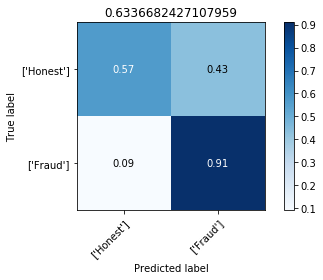

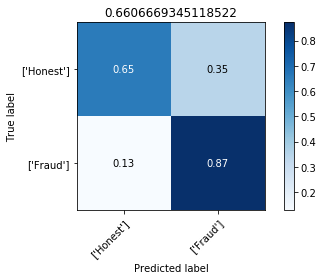

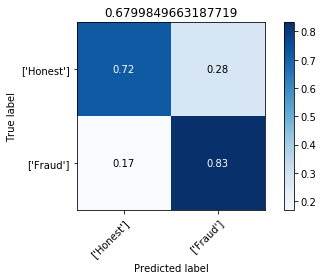

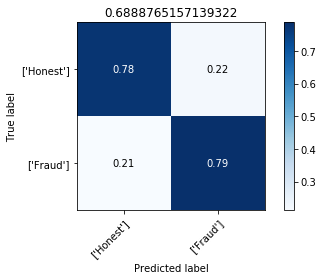

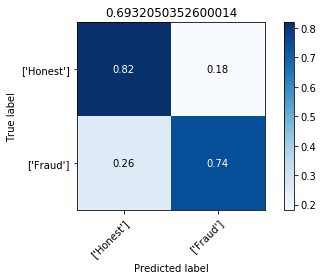

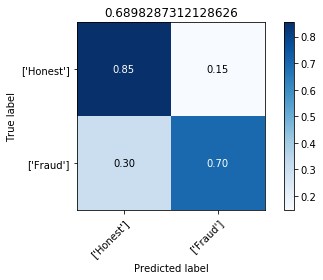

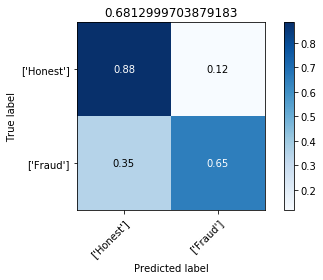

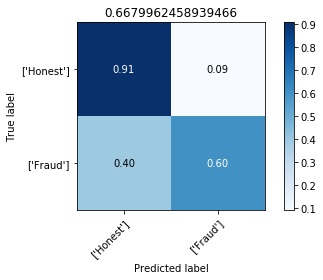

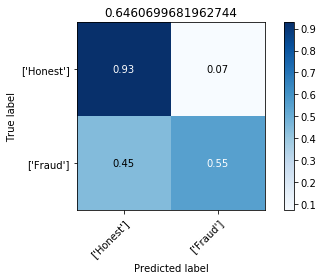

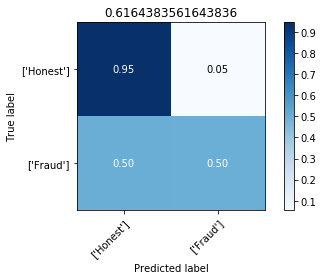

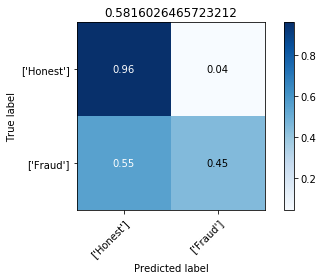

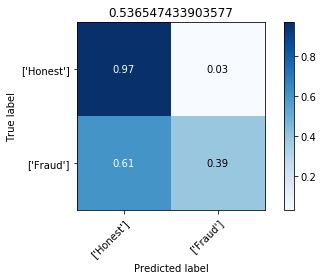

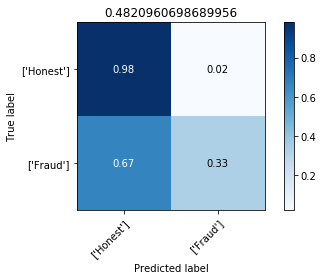

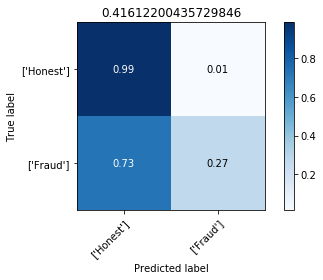

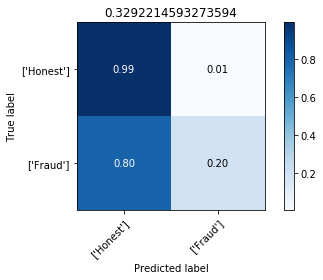

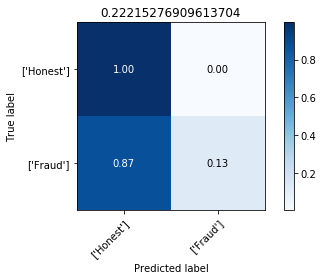

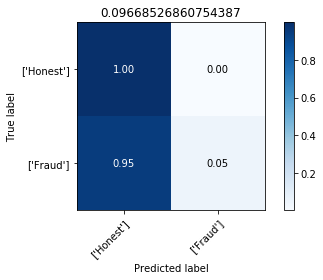

In [27]:
for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)